# Band tailing from Cu-Zn disorder induced potential fluctuations in CZTS

This notebook computes the standard deviation of the distribution of on-site electrostatic potentials outputted from our Monte Carlo model of Cu-Zn disorder in CZTS.

The standard deviation of the distribution for Cu ions is used to infer band tailing of the VBM and the distribution for Sn ions is used to infer band tailing of the CBM due to the pDOS composition of the band extrema in CZTS, as shown below in the band structure.

Later in the notebook visuals can be produced of spatial variation in the electrostatic potentials for Cu or Sn in 2D slices.

![image](https://user-images.githubusercontent.com/8959058/42238164-df8cc45a-7ef7-11e8-9399-9ded2c339541.png)
(Fig. from doi: 10.1002/adma.201203146)

## Converting potentials from Eris internal units to V
V = $\frac{Q}{4 \pi \epsilon_{0} \epsilon_{CZTS} r}$
- Q = bare formal charge of ion * e
- e = $1.6\times10^{-19} C$ 
- $\epsilon_{0} = 8.85 \times 10^{-12} C V^{-1} m^{-1}$ 
- $\epsilon_{CZTS}$ for perfect CZTS (most similar case to our lattice model) = 9.9 (doi: 10.1063/1.5028186)
- 1 Eris lattice unit = 2.72 Angstroms = 2.72 $\times10^{-10}$ m
- In Eris, only consider (bare formal charge)/ d, where d is ion separation in lattice units
- To convert from Eris internal units to V, multiply result by conversion factor: $\frac{e}{4\pi \epsilon_{0} \epsilon_{CZTS} * 2.72 \times10^{-10}}$ = 0.534 


## Standard deviation of Cu and Sn distributions
Note that for the perfectly ordered lattice at T=0K there is only one crystallographically unique Sn, therefore there is only 1 value for the potential and hence the standard deviation of the electrostatic potential is zero. For Cu there are 2 distinct sites (one in the Cu-Zn plane and one in the Cu-Sn plane), therefore the standard deviation is non-zero even for the ordered lattice.

Please enter the temperature range of the simulation performed in the script below.

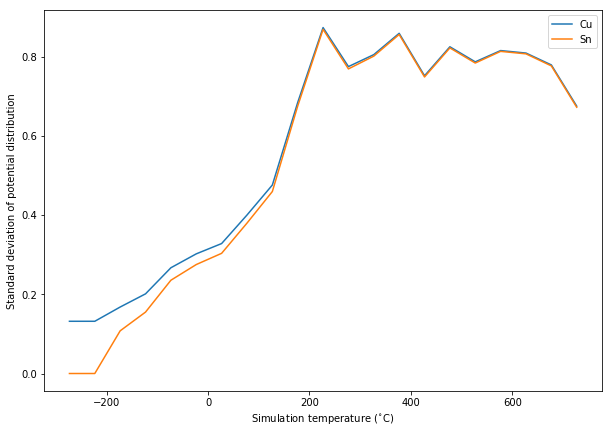

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### USER INPUTS ###
# Temperature range and step size from Eris simulation (as defined in cx1 submission script)
TMIN = 0
TMAX = 1000
TSTEP = 50
###################

### ADD IN CONVERSION FROM INTERNAL ERIS UNITS TO V HERE ###
unit_conversion = 0.534 #Convert from internal Eris units to V (see above for derivation)

Cu_sd_file = open("Cu_sd_vs_T.dat", "w")
Cu_sd_list = []
Sn_sd_file = open("Sn_sd_vs_T.dat", "w")
Sn_sd_list = []
T_list = np.arange(TMIN, TMAX+TSTEP, TSTEP)

for T in range(TMIN, TMAX+TSTEP, TSTEP):
    T_formatted = str(T).zfill(4)
    Cu_file = "Cu_potentials_T_"+str(T_formatted)+"K.dat"
    Sn_file = "Sn_potentials_T_"+str(T_formatted)+"K.dat"
    Cu_potentials = np.genfromtxt(Cu_file)
    Sn_potentials = np.genfromtxt(Sn_file)
    Cu_sd = np.std(Cu_potentials)
    Cu_sd_list.append(Cu_sd*unit_conversion)
    Cu_sd_file.write(str(Cu_sd*unit_conversion)+" ")
    Cu_sd_file.write(str(T)+"\n")
    Sn_sd = np.std(Sn_potentials)
    Sn_sd_list.append(Sn_sd*unit_conversion)
    Sn_sd_file.write(str(Sn_sd*unit_conversion)+" ")
    Sn_sd_file.write(str(T)+"\n")

Cu_sd_file.close()
Sn_sd_file.close()

fig = plt.figure(figsize = (10,7))
#plt.xlim(0,700)
plt.plot(T_list-273.15, Cu_sd_list, label="Cu")
plt.plot(T_list-273.15, Sn_sd_list, label="Sn")
plt.xlabel("Simulation temperature ($^{\circ}$C)")
plt.ylabel("Standard deviation of potential distribution (V)")
plt.legend()
plt.show()

Compare the standard deviation of the electrostatic potential distributions as a function of temperature to the extent of Cu-Zn disorder as a function of temperature as defined by the Q order parameter:

Q = [ (Cu-on-2c + Zn-on-2d) - (Zn-on-2c + Cu-on-2d) ] / [ (Cu-on-2c + Zn-on-2d) + (Zn-on-2c + Cu-on-2d) ]

Where in a fully ordered system, all 2c sites should be occupied by Cu and all 2d sites by Zn. This situation corresponds to Q=1. For a fully disordered system, there is no preference for Cu or Zn to occupy the correct crystallographic site and Q=0.

![image](https://user-images.githubusercontent.com/8959058/42238183-e95d3410-7ef7-11e8-9f04-71e5677676dc.png)

## 2D spatial variation in electrostatic potential
The script below can be used to generate plots showing the spatial variation of Cu or Sn in 2D slices of the lattice. In eris odd slice numbers correspond to Cu-Zn planes, even correspond to Cu-Sn planes.

In each plot, the mean of the potential distribution is subtracted from each on-site potential to show regions of higher or lower potential.

Please enter into the script below the simulation temperature and slice number you wish to plot (where the total number of slices is the Z dimension of your Eris lattice). If you enter an even number for the slice, plots will be generated for both Cu and Sn, if you enter an odd number only a plot for Cu will be generated.

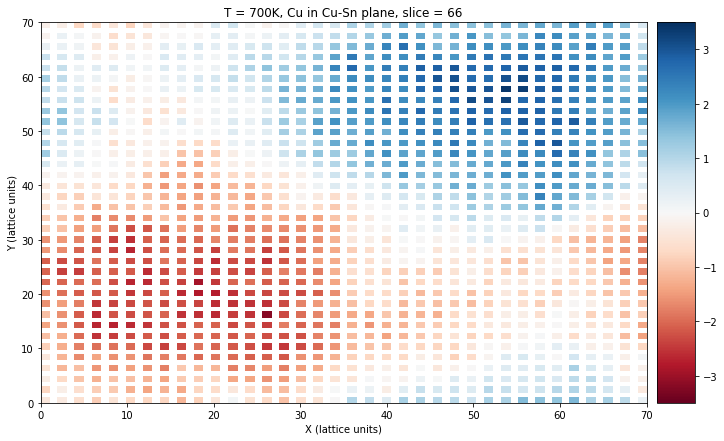

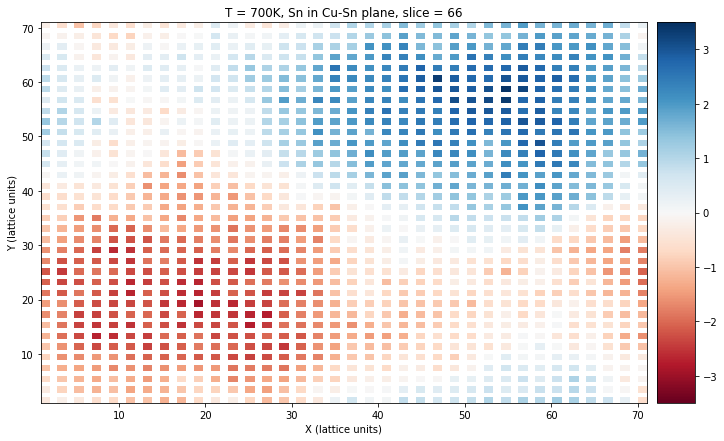

In [34]:
# NOTE: When using 'mean' method for histogram plot NaNs show up as white (i.e. sites not in data file in plots below)
# Also, Cu's move when plotting Cu-Zn plane slices but not when plotting Cu-Sn plane slices
# This is the only allowed disorder process in Eris currently (02.07.18) so is to be expected

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

### USER INPUTS ###
T = 700 # in K
slice_num = 66
X_dim = 72
Y_dim = 72
Z_dim = 72

# Set params for plots
cmap = 'RdBu' # Colormap (see matplotlib colormap docs for options)
pmin = -3.5 # Set limits for histogram plot of (onsite potential) - (mean potential)
pmax = 3.5
bins = X_dim-1 # Test bins in histogram plots
#bins = X_dim/2
# Bin choice a little arbitrary. 
# For on-lattice data may be better to read in X, Y coords to 2D array and use plt.imshow instead?
# e.g. plt.imshow(eris_pots_as_2d_array, cmap=plt.cm.cmap)  #cmap defined above


###################

unit_conversion = 0.534 #Convert from internal Eris units to V (see above for derivation)
T_formatted = str(T).zfill(4)
slice_formatted = str(slice_num).zfill(2)

# Generating plot for just Cu's in Cu-Zn slice
if (slice_num%2 == 1):
    data_file = "Cu_potentials_T_"+str(T_formatted)+"K_slice_z="+str(slice_formatted)+".dat"
    # Reading in data from eris output file
    CuZnSlice = np.genfromtxt(data_file, delimiter = ' ')
    x_vals = CuZnSlice[:,0]
    y_vals = CuZnSlice[:,1]
    pots = CuZnSlice[:,2]
    pot_mean = np.mean(pots)
    pot_fluc = CuZnSlice[:,2] - pot_mean
    pot_fluc_in_V = pot_fluc * unit_conversion
    # Generate 2D histogram of (on-site potential) - (mean potential) for Cu in Cu-Zn plane
    H, xedges, yedges, binnumber = stats.binned_statistic_2d(x_vals, y_vals, values = pot_fluc, statistic='mean' , bins = [bins,bins])
    XX, YY = np.meshgrid(xedges, yedges)
    fig = plt.figure(figsize = (13,7))
    ax1=plt.subplot(111)
    plt.title("T = "+str(T)+"K, Cu in Cu-Zn plane, slice = "+ str(slice_num))
    plot1 = ax1.pcolormesh(XX,YY,H.T, cmap=cmap, vmin=pmin, vmax=pmax)
    cbar = plt.colorbar(plot1,ax=ax1, pad = .015, aspect=10)


    
# Generating separate plots for Cu's and Sn's in Cu-Sn slice   
if (slice_num%2 == 0):
    # Set up subplots
    Cu_data_file = "Cu_potentials_T_"+str(T_formatted)+"K_slice_z="+str(slice_formatted)+".dat"
    Sn_data_file = "Sn_potentials_T_"+str(T_formatted)+"K_slice_z="+str(slice_formatted)+".dat"
    # Reading in data from eris output file for Cu
    Cu_CuSnSlice = np.genfromtxt(Cu_data_file, delimiter = ' ')
    Cu_x_vals = Cu_CuSnSlice[:,0]
    Cu_y_vals = Cu_CuSnSlice[:,1]
    Cu_pots = Cu_CuSnSlice[:,2]
    Cu_pot_mean = np.mean(Cu_pots)
    Cu_pot_fluc = Cu_CuSnSlice[:,2] - Cu_pot_mean
    Cu_pot_fluc_in_V = Cu_pot_fluc * unit_conversion
    # Generate 2D histogram of (on-site potential) - (mean potential) for Cu in Cu-Sn plane
    H, xedges, yedges, binnumber = stats.binned_statistic_2d(Cu_x_vals, Cu_y_vals, values = Cu_pot_fluc, statistic='mean' , bins = [bins,bins])
    XX, YY = np.meshgrid(xedges, yedges)
    fig = plt.figure(figsize = (13,7))
    ax1=plt.subplot(111)
    plt.title("T = "+str(T)+"K, Cu in Cu-Sn plane, slice = "+ str(slice_num))
    plot1 = ax1.pcolormesh(XX,YY,H.T, cmap=cmap, vmin=pmin, vmax=pmax)
    cbar = plt.colorbar(plot1,ax=ax1, pad = .015, aspect=10)
    plt.xlabel('X (lattice units)')
    plt.ylabel('Y (lattice units)')
    # Reading in data from eris output file for Sn
    Sn_CuSnSlice = np.genfromtxt(Sn_data_file, delimiter = ' ')
    Sn_x_vals = Sn_CuSnSlice[:,0]
    Sn_y_vals = Sn_CuSnSlice[:,1]
    Sn_pots = Sn_CuSnSlice[:,2]
    Sn_pot_mean = np.mean(Sn_pots)
    Sn_pot_fluc = Sn_CuSnSlice[:,2] - Sn_pot_mean
    Sn_pot_fluc_in_V = Sn_pot_fluc * unit_conversion
    # Generate 2D histogram of (on-site potential) - (mean potential) for Sn in Cu-Sn plane
    H, xedges, yedges, binnumber = stats.binned_statistic_2d(Sn_x_vals, Sn_y_vals, values = Sn_pot_fluc, statistic='mean' , bins = [bins,bins])
    XX, YY = np.meshgrid(xedges, yedges)
    fig2 = plt.figure(figsize = (13,7))
    ax2=plt.subplot(111)
    plt.title("T = "+str(T)+"K, Sn in Cu-Sn plane, slice = "+ str(slice_num))
    plot2 = ax2.pcolormesh(XX,YY,H.T, cmap=cmap, vmin=pmin, vmax=pmax)
    cbar = plt.colorbar(plot2,ax=ax2, pad = .015, aspect=10)
    

plt.xlabel('X (lattice units)')
plt.ylabel('Y (lattice units)')
plt.show()
